# Neural Style Transfer for modelling artistic images
By Manikanta Chunduru Balaji 

#Import modules

In [1]:
#import modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from keras.preprocessing.image import load_img

In [2]:
#set base image path and reference image path
#base_image_path="/content/drive/MyDrive/Colab Notebooks/Images/pedro-monteiro-HfIex7qwTlI-unsplash.jpg"
base_image_path="/content/drive/MyDrive/Colab Notebooks/Images/pedro-lastra-Nyvq2juw4_o-unsplash.jpg"
#/content/drive/MyDrive/Colab Notebooks/Images/pedro-lastra-Nyvq2juw4_o-unsplash.jpg
style_reference_imagepath="/content/drive/MyDrive/Colab Notebooks/Style1.jpg"
#style_reference_imagepath="/content/drive/MyDrive/Colab Notebooks/Images/Pablopicasso.jpg"

In [3]:
#defining dimensions of base and content image
base_image=load_img(base_image_path)
width, height = base_image.size
img_nrows = 400
img_ncols = int(width * img_nrows / height)
print(f'Size used for resizing rows:{img_nrows},columns:{img_ncols}')

Size used for resizing rows:400,columns:650


#Visualize the Content and Style Image

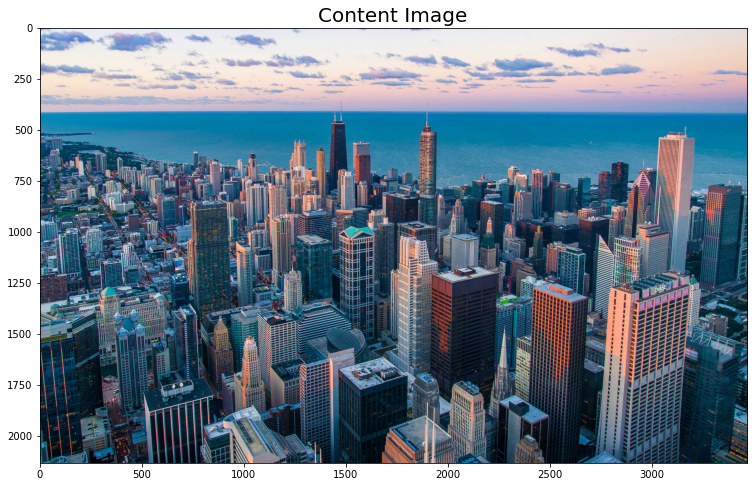

In [4]:
#Plot Content Image
plt.figure(figsize=(16, 8))
plt.title('Content Image',fontsize=20)
plt.imshow(base_image)


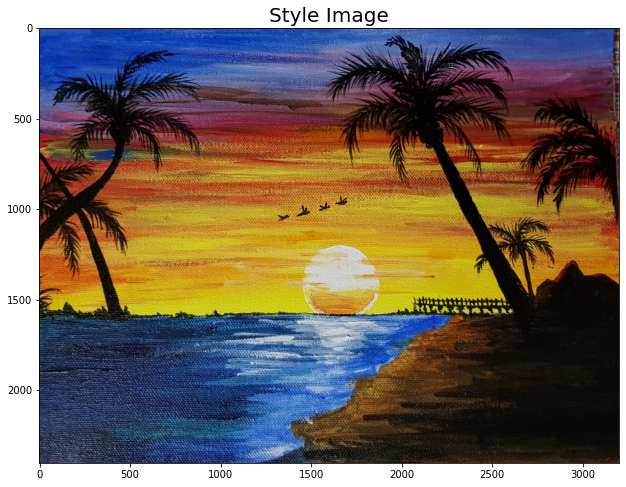

In [5]:
#Plot Style Image
plt.figure(figsize=(16, 8))
plt.title('Style Image',fontsize=20)
style_image=load_img(style_reference_imagepath)
plt.imshow(style_image)

In [6]:
#We define a preprocess method which will load the image of appropriate 
#size and converts into a tensor
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [7]:
#Deprocess function is utilized to convert the final tensor to a 
#valid image and remove zero center by mean pixel 
#and finally coverting BGR to RGB in order to easily compare with content and style images
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Loss Functions

In [8]:
#Content loss is found by taking the reduce sum between square of base and combined image 
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [9]:
#gram matrix involves calculating the dot products with respect to style and reconstructed image
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [10]:
#Style loss is computed for the style and reconstructed image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

#VGG Model 


In [11]:
# VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [19]:

# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    

]
# style_layer_names = [
#                      "block1_conv1"
# ]
# The layer to use for the content loss.
content_layer_name = "block2_conv2"



In [20]:
content_layer_name

'block2_conv2'

In [13]:
#Compute losss
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    if content_layer_name != "":
      layer_features = features[content_layer_name]
      base_image_features = layer_features[0, :, :, :]
      combination_features = layer_features[2, :, :, :]
      print('Layer Feature for Content Layers :: '+str(layer_features))
      print('Base Image Feature :: '+str(base_image_features))
      print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
      loss = loss + content_weight * content_loss(
          base_image_features, combination_features
      )
    
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        print('Layer Feature for Style Layers :: '+str(layer_features))
        print('Style Image Feature :: '+str(style_reference_features))
        print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    return loss

In [14]:
#method to compute gradient and loss using tf.GradientTape
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [26]:
# Weights of the different loss components

style_weight = 1e-6
content_weight = 2.5e-8

#Training loop with SGD optimizer

In [27]:
result_prefix="CombinationImage"
#using SGD optimizer
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_imagepreprocessed=preprocess_image(base_image_path)
style_imagepreprocessed=preprocess_image(style_reference_imagepath)
combination_image = tf.Variable(preprocess_image(base_image_path))
losses=[]
iterations = 4000
for i in range(1, iterations + 1):
  #compute loss and gradient
    loss, grads = compute_loss_and_grads(
        combination_image, base_imagepreprocessed, style_imagepreprocessed
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
        losses.append(loss)

Layer Feature for Content Layers :: Tensor("model/block2_conv2/Relu:0", shape=(3, 200, 325, 128), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(200, 325, 128), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(200, 325, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("model/block1_conv1/Relu:0", shape=(3, 400, 650, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 650, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 650, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("model/block2_conv1/Relu:0", shape=(3, 200, 325, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 325, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 325, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("model/block3_conv1/Relu:

Text(0.5, 1.0, 'Model Loss for 40 iterations')

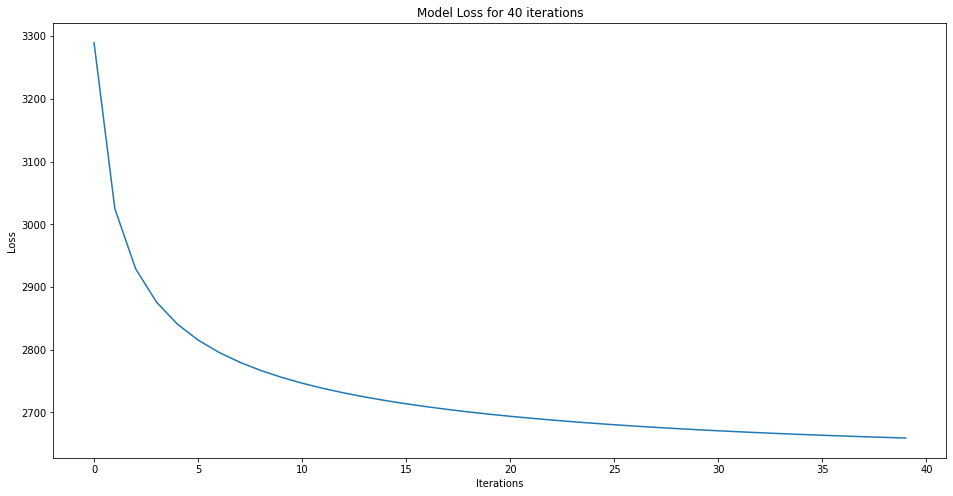

In [28]:
plt.figure(figsize=(16,8))
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Model Loss for 40 iterations")

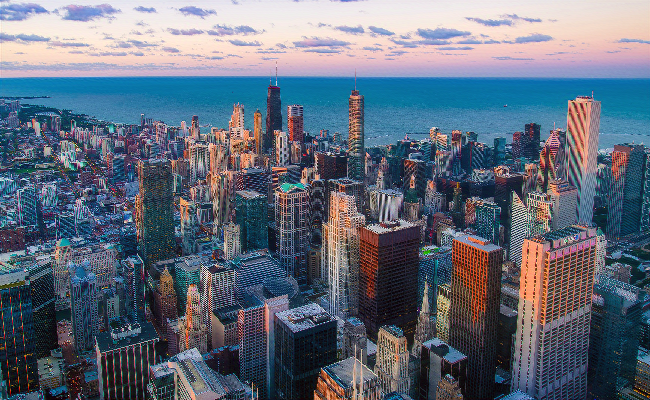

In [29]:
#plotting image after 40 iterations
from IPython.display import Image, display
display(Image(result_prefix + "_at_iteration_40.png"))

#Training loop with Adam optimizer

In [21]:
result_prefix="CombinationAdam"
optimizer =keras.optimizers.Adam(learning_rate=5)

base_imagepreprocessed=preprocess_image(base_image_path)
style_imagepreprocessed=preprocess_image(style_reference_imagepath)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
losses=[]
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_imagepreprocessed, style_imagepreprocessed
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
        losses.append(loss)

Layer Feature for Content Layers :: Tensor("model/block2_conv2/Relu:0", shape=(3, 200, 325, 128), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(200, 325, 128), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(200, 325, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("model/block1_conv1/Relu:0", shape=(3, 400, 650, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 650, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 650, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("model/block2_conv1/Relu:0", shape=(3, 200, 325, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 325, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 325, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("model/block3_conv1/Relu:

Text(0.5, 1.0, 'Model Loss for 40 iterations')

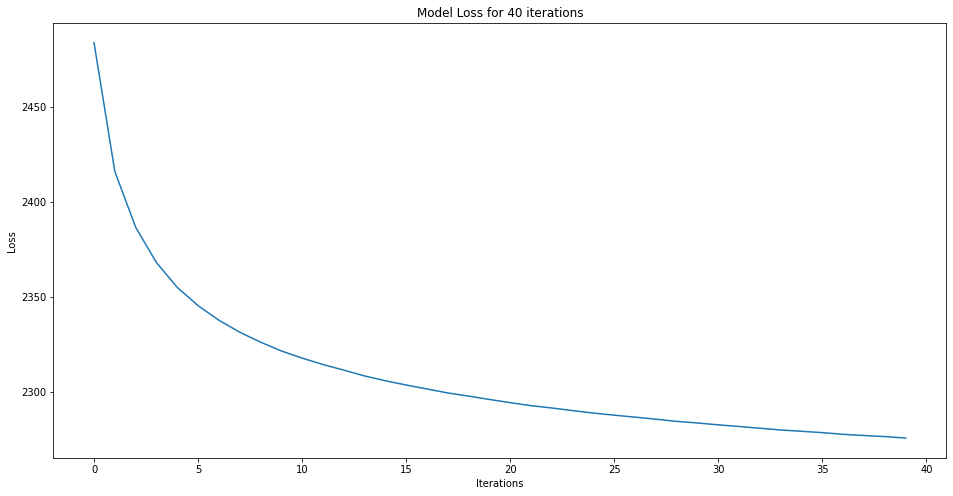

In [22]:
plt.figure(figsize=(16,8))
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Model Loss for 40 iterations")


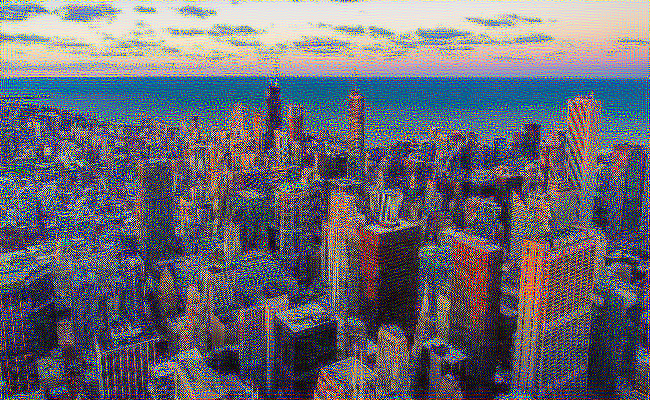

In [25]:
from IPython.display import Image, display
display(Image(result_prefix + "_at_iteration_40.png"))